1.0 Dataprocessing
------------------------------------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:

labels=['0','1','2','3','4','5','6','7','8','9']
class data:
  def __init__(self,path,label):
    self.img=plt.imread(path)
    self.label=label
  def normalize(self,scalar=1,shift=0):
    self.img=(self.img+shift)/scalar
dir_path="/content/drive/MyDrive/Colab Notebooks/data/MNIST/"
dataset=[]
for label in labels:
  for i in range(128):
    path=dir_path+label+"/"+str(i)+".jpg"
    dataset.append(data(path,label))

normalize only map 0-255 gray level to 0-1

In [4]:
#print(dataset[0].img)
#plt.imshow(dataset[0].img)
for data in dataset:
  data.normalize(scalar=256)
#print(dataset[0].img)


random split data into train and test

In [5]:
train_data=[]
test_data=[]
for i,label in enumerate(labels):
  tmp=dataset[i*128:(i+1)*128]
  np.random.shuffle(tmp)
  train_data+=tmp[0:96]
  test_data+=tmp[96:]

1.1 Least square  
------------------------------------------------

In [6]:
#obtain weight
X_list=[]
for i,data in enumerate(train_data):
  flat_data=data.img.flatten()
  flat_data=np.append([1],flat_data)
  X_list.append(flat_data)
X_matrix=np.array(X_list)
#print(X_matrix.shape)

T_list=[]
for i,data in enumerate(train_data):
  onehot=np.zeros(len(labels))
  onehot[int(data.label)]=1
  T_list.append(onehot)
T_matrix=np.array(T_list)


In [7]:

tmp_matrix=X_matrix.T@X_matrix
tmp_matrix=np.linalg.pinv(tmp_matrix)
W_matrix=tmp_matrix@X_matrix.T@T_matrix

In [8]:
#simple test
"""
flat_data=dataset[127].img.flatten()
flat_data=np.append([1],flat_data)
logits=W_matrix.T@flat_data
print(logits)
predict=np.argmax(logits)
print(labels[predict])
"""

'\nflat_data=dataset[127].img.flatten()\nflat_data=np.append([1],flat_data)\nlogits=W_matrix.T@flat_data\nprint(logits)\npredict=np.argmax(logits)\nprint(labels[predict])\n'

for accuracy and loss

In [9]:
def onehot(label,dim=10):
  ret=np.zeros(dim)
  ret[int(label)]=1
  return ret
  
#train part
train_correct=0
train_loss=0
for i,data in enumerate(train_data):
  flat_data=data.img.flatten()
  flat_data=np.append([1],flat_data)
  logits=W_matrix.T@flat_data
  predict=np.argmax(logits)
  if predict==int(data.label):
    train_correct+=1
  diff=logits-onehot(data.label)
  train_loss+=diff.T@diff
#test part
test_correct=0
test_loss=0
for i,data in enumerate(test_data):
  flat_data=data.img.flatten()
  flat_data=np.append([1],flat_data)
  logits=W_matrix.T@flat_data
  predict=np.argmax(logits)
  if predict==int(data.label):
    test_correct+=1
  diff=logits-onehot(data.label)
  test_loss+=diff.T@diff

In [10]:
#summary of 1.1 accuracy and loss
print("--"*8,"Train","--"*8)
print("data size=",len(train_data))
print("accuracy=",train_correct/len(train_data))
print("loss=",train_loss)

print("--"*8,"Test","--"*8)
print("data size=",len(test_data))
print("accuracy=",test_correct/len(test_data))
print("loss=",test_loss)

---------------- Train ----------------
data size= 960
accuracy= 1.0
loss= 55.19954125960125
---------------- Test ----------------
data size= 320
accuracy= 0.459375
loss= 4814.48523922774


1.2 Logistic Regression
--------------------------------------------------------------------

###Functions

In [11]:
def softmax(logits):
  return np.exp(logits)/sum(np.exp(logits))

In [12]:
def cross_entropy_loss(logits,label):

  return sum(np.log(softmax(logits))*onehot(label))

In [13]:
softmax(logits)
cross_entropy_loss(logits,label)

-1.711150816829419

In [14]:
def gradient_cross_entropy(logits,label):
  return (softmax(logits)-onehot(label))
W_batch=np.zeros(shape=(785,10))
W_SGD=np.zeros(shape=(785,10))
W_mini_batch=np.zeros(shape=(785,10))


In [15]:
def test_eval(W,test_data):

  test_correct=0
  test_loss=0
  N=len(test_data)
  for i,data in enumerate(test_data):
    flat_data=data.img.flatten()
    flat_data=np.append([1],flat_data)
    logits=W.T@flat_data
    test_loss+=cross_entropy_loss(logits,data.label)


    predict=np.argmax(logits)
    if predict==int(data.label):
      test_correct+=1

  return (test_loss/N)*-1,test_correct/N

###batch GD

In [16]:
epochs=70
lr=0.001
batch_train_acc=[]
batch_train_loss=[]
batch_test_acc=[]
batch_test_loss=[]
W_batch=np.zeros(shape=(785,10))
for epoch in range(epochs):

  loss=0
  correct=0
  step=np.zeros(shape=(785,10)) 
  for i in range(len(train_data)):
    data=train_data[i]
    flat_data=data.img.flatten()
    flat_data=np.append([1],flat_data)
    logits=W_batch.T@flat_data
    
    gradient=gradient_cross_entropy(logits,data.label)
    step+=flat_data.reshape(-1,1)@gradient.reshape(1,-1)

    loss+=cross_entropy_loss(logits,data.label)
    predict=np.argmax(logits)
    if predict==int(data.label):
      correct+=1
  W_batch=W_batch-lr*step #update

  acc=correct/len(train_data)
  loss*=-1
  loss/=len(train_data)
  batch_train_loss.append(loss)
  batch_train_acc.append(acc)

  test_loss,test_acc=test_eval(W_batch,test_data)
  batch_test_loss.append(test_loss)
  batch_test_acc.append(test_acc)
  if(epoch%10==9):
    print("at epoch=",epoch,"train loss=",loss)
    print("            train acc=",acc)
    print("            test loss=",test_loss)
    print("            test acc=",test_acc)


at epoch= 9 train loss= 1.052182528729072
            train acc= 0.75
            test loss= 0.8232187193594903
            test acc= 0.70625
at epoch= 19 train loss= 0.48412293853391997
            train acc= 0.8447916666666667
            test loss= 0.5447528799916085
            test acc= 0.81875
at epoch= 29 train loss= 0.3186295969392896
            train acc= 0.9260416666666667
            test loss= 0.43559055970194
            test acc= 0.878125
at epoch= 39 train loss= 0.27655499558013424
            train acc= 0.9354166666666667
            test loss= 0.4192584459093676
            test acc= 0.86875
at epoch= 49 train loss= 0.24709523238087233
            train acc= 0.9447916666666667
            test loss= 0.4092300137616414
            test acc= 0.878125
at epoch= 59 train loss= 0.2238970285860512
            train acc= 0.9510416666666667
            test loss= 0.4023690859785626
            test acc= 0.878125
at epoch= 69 train loss= 0.20495073468267136
            train a

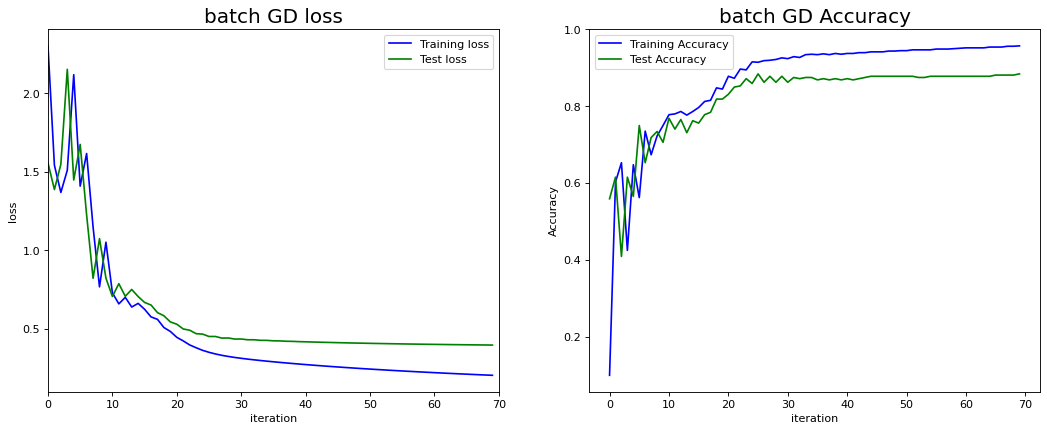

In [17]:
fig = plt.figure(figsize=(16, 6), dpi=80)
#SGD loss
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(121)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('loss', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('batch GD loss', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(batch_train_loss)),batch_train_loss, color='blue',label="Training loss")
plt.plot(range(len(batch_test_loss)),batch_test_loss, color='green',label="Test loss")

plt.legend()
#SGD acc
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(122)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('Accuracy', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('batch GD Accuracy', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(batch_train_acc)),batch_train_acc, color='blue',label="Training Accuracy")
plt.plot(range(len(batch_test_acc)),batch_test_acc, color='green',label="Test Accuracy")

plt.legend()
plt.show()

###SGD








In [18]:
epochs=70
lr=0.001
SGD_train_acc=[]
SGD_train_loss=[]
SGD_test_acc=[]
SGD_test_loss=[]
W_SGD=np.zeros(shape=(785,10))
for epoch in range(epochs):
  iter_list=np.arange(len(train_data))
  np.random.shuffle(iter_list)
  loss=0
  correct=0
  for i in iter_list:
    data=train_data[i]
    flat_data=data.img.flatten()
    flat_data=np.append([1],flat_data)
    logits=W_SGD.T@flat_data
    
    gradient=gradient_cross_entropy(logits,data.label)
    step=flat_data.reshape(-1,1)@gradient.reshape(1,-1)
    W_SGD=W_SGD-lr*step

    loss+=cross_entropy_loss(logits,data.label)
    predict=np.argmax(logits)
    if predict==int(data.label):
      correct+=1

  acc=correct/len(train_data)
  loss*=-1
  loss/=len(train_data)
  SGD_train_loss.append(loss)
  SGD_train_acc.append(acc)

  test_loss,test_acc=test_eval(W_SGD,test_data)
  SGD_test_loss.append(test_loss)
  SGD_test_acc.append(test_acc)
  if(epoch%10==9):
    print("at epoch=",epoch,"train loss=",loss)
    print("            train acc=",acc)
    print("            test loss=",test_loss)
    print("            test acc=",test_acc)



at epoch= 9 train loss= 0.5718629248592596
            train acc= 0.8864583333333333
            test loss= 0.6203276027260938
            test acc= 0.8625
at epoch= 19 train loss= 0.41012646130915104
            train acc= 0.90625
            test loss= 0.500787886184691
            test acc= 0.8625
at epoch= 29 train loss= 0.3371186071831743
            train acc= 0.925
            test loss= 0.45398930961070283
            test acc= 0.878125
at epoch= 39 train loss= 0.2912984416112413
            train acc= 0.9375
            test loss= 0.4297377538532525
            test acc= 0.884375
at epoch= 49 train loss= 0.2579921382886282
            train acc= 0.94375
            test loss= 0.4156910271444606
            test acc= 0.878125
at epoch= 59 train loss= 0.23265886500547303
            train acc= 0.9458333333333333
            test loss= 0.4061633893913707
            test acc= 0.878125
at epoch= 69 train loss= 0.21215386788617557
            train acc= 0.9520833333333333
         

learning curve of SGD

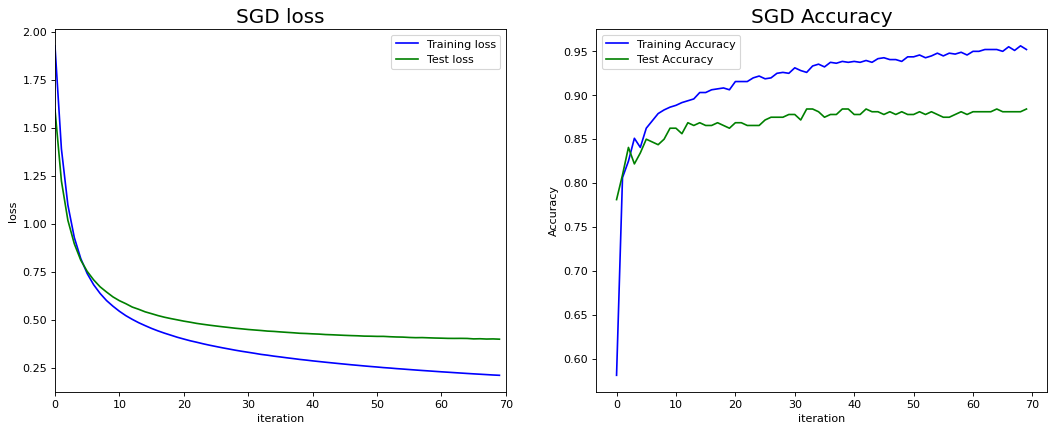

In [19]:
fig = plt.figure(figsize=(16, 6), dpi=80)
#SGD loss
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(121)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('loss', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('SGD loss', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(SGD_train_loss)),SGD_train_loss, color='blue',label="Training loss")
plt.plot(range(len(SGD_test_loss)),SGD_test_loss, color='green',label="Test loss")

plt.legend()
#SGD acc
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(122)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('Accuracy', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('SGD Accuracy', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(SGD_train_acc)),SGD_train_acc, color='blue',label="Training Accuracy")
plt.plot(range(len(SGD_test_acc)),SGD_test_acc, color='green',label="Test Accuracy")

plt.legend()
plt.show()

###mini-batch SGD

In [20]:
epochs=70
lr=0.001
batchsize=32
batchSGD_train_acc=[]
batchSGD_train_loss=[]
batchSGD_test_acc=[]
batchSGD_test_loss=[]
W_batchSGD=np.zeros(shape=(785,10))
for epoch in range(epochs):
  iter_list=np.arange(len(train_data))
  np.random.shuffle(iter_list)
  loss=0
  correct=0
  step=np.zeros(shape=(785,10))
  for count,i in enumerate(iter_list):
    data=train_data[i]
    flat_data=data.img.flatten()
    flat_data=np.append([1],flat_data)
    logits=W_batchSGD.T@flat_data
    
    gradient=gradient_cross_entropy(logits,data.label)
    step+=flat_data.reshape(-1,1)@gradient.reshape(1,-1)
    if (count%batchsize)==(batchsize-1):
      W_batchSGD=W_batchSGD-lr*step
      step=np.zeros(shape=(785,10))

    loss+=cross_entropy_loss(logits,data.label)
    predict=np.argmax(logits)
    if predict==int(data.label):
      correct+=1

  acc=correct/len(train_data)
  loss*=-1
  loss/=len(train_data)
  batchSGD_train_loss.append(loss)
  batchSGD_train_acc.append(acc)

  test_loss,test_acc=test_eval(W_batchSGD,test_data)
  batchSGD_test_loss.append(test_loss)
  batchSGD_test_acc.append(test_acc)
  if(epoch%10==9):
    print("at epoch=",epoch,"train loss=",loss)
    print("            train acc=",acc)
    print("            test loss=",test_loss)
    print("            test acc=",test_acc)

at epoch= 9 train loss= 0.570848519648226
            train acc= 0.8864583333333333
            test loss= 0.6208271132072571
            test acc= 0.865625
at epoch= 19 train loss= 0.41046867214435084
            train acc= 0.9104166666666667
            test loss= 0.5001187146298125
            test acc= 0.86875
at epoch= 29 train loss= 0.3369029137436173
            train acc= 0.928125
            test loss= 0.45408222321759134
            test acc= 0.871875
at epoch= 39 train loss= 0.29095612089770684
            train acc= 0.9375
            test loss= 0.42940378759796693
            test acc= 0.878125
at epoch= 49 train loss= 0.2581395171769071
            train acc= 0.94375
            test loss= 0.4155922632122576
            test acc= 0.878125
at epoch= 59 train loss= 0.23224444026435467
            train acc= 0.9520833333333333
            test loss= 0.40664531636734447
            test acc= 0.88125
at epoch= 69 train loss= 0.21178073330977504
            train acc= 0.9583333

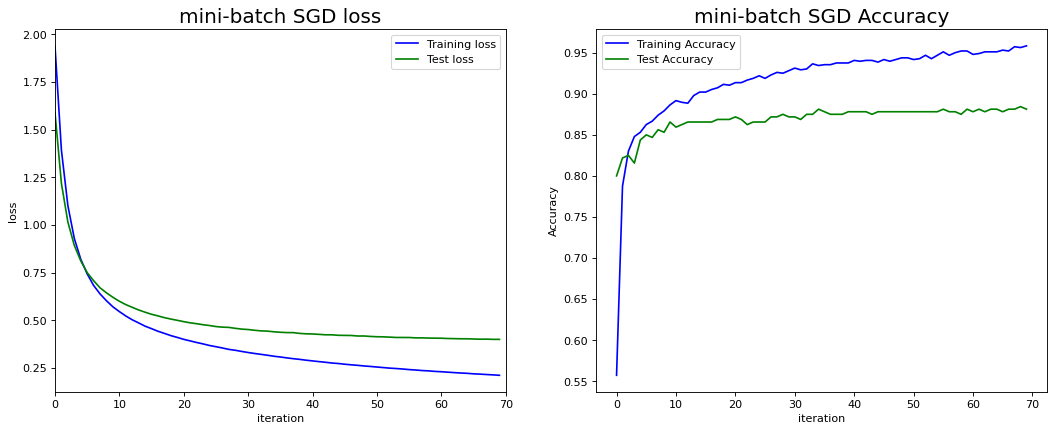

In [21]:
fig = plt.figure(figsize=(16, 6), dpi=80)
#SGD loss
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(121)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('loss', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('mini-batch SGD loss', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(batchSGD_train_loss)),batchSGD_train_loss, color='blue',label="Training loss")
plt.plot(range(len(batchSGD_test_loss)),batchSGD_test_loss, color='green',label="Test loss")

plt.legend()
#SGD acc
plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍
plt.subplot(122)
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('Accuracy', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('mini-batch SGD Accuracy', fontsize="18") # 設定圖表標題內容及大小


plt.plot(range(len(batchSGD_train_acc)),batchSGD_train_acc, color='blue',label="Training Accuracy")
plt.plot(range(len(batchSGD_test_acc)),batchSGD_test_acc, color='green',label="Test Accuracy")

plt.legend()
plt.show()

1.3 discussion
----------------


1-1.   **for least square**  

we can find the fact that least square error isn't a good criterion for solving
classification problem.  
Because it perform like regression with K dimension target,try to minimize the "distance" between prediction and target.  
But "distance" isn't a meaningful property we care about. What we actually care is the "probability" to predict as target.  
This lead to the criterion related to entropy and likelihood  

1-2.   **logistic regression**  

logistic regression use the criterion based on likelihood function which leads to the "cross entropy loss"  
and imply the sigmoid and softmax fuction achieveing the property of "breaking linearity".  
This make logistic regression an intuitive and powerful approach.  
Between three approach for gradient descent,bacth GD perform most stable and SGD perform more noising.  
Although batch GD may look like a best approach, but SGD can converge faster and provide a oppotunity to jump off the local minimum.  
So the compromise between them which is mini-batch SGD are generally perform in most cases.

#2.0 dataprocessing


In [22]:
import pandas as pd
dir_path="/content/drive/MyDrive/Colab Notebooks/data/gaussian process"
X_data=pd.read_csv(dir_path+"/x.csv",header=None)
T_data=pd.read_csv(dir_path+"/t.csv",header=None)
X=pd.DataFrame.to_numpy(X_data)
T=pd.DataFrame.to_numpy(T_data)

N=300
iter_list=np.arange(N)
np.random.shuffle(iter_list)
X_shuffle=[]
T_shuffle=[]
for i in iter_list:
 X_shuffle.append(np.ndarray.item(X[i]))
 T_shuffle.append(np.ndarray.item(T[i]))
X_shuffle=np.array(X_shuffle)
T_shuffle=np.array(T_shuffle)

X_train=X_shuffle[:150]
T_train=T_shuffle[:150]
X_test=X_shuffle[150:]
T_test=T_shuffle[150:]

#2.1 plynomial basis

In [23]:
def phi(x,order=2): #return list
  phi=[]
  phi.append(1)
  cur=0
  if not isinstance(x,list):
    x=[x]

  for i in range(order):
    end=len(phi)
    while cur<end:
      for j in range(len(x)):    
        phi.append(phi[cur]*x[j]) #input 1x ndarray x[j]
      cur+=1
    cur=end
  return phi
t=phi(X_train[0])
print(type(X_train[10]))
print(t)

<class 'numpy.float64'>
[1, 9.948079261017435, 98.9642809834852]


In [24]:
N=150
X_phi=[]
beta=1
for i in range(N):
  X_phi.append(phi(X_train[i]))
X_phi=np.array(X_phi)
gram_matrix=X_phi@X_phi.T

C=gram_matrix+np.identity(N)/beta

make prediction

In [25]:
def make_k_vector(X_train,x):
  vector=[]
  for i in range(len(X_train)):
    vector.append(np.array(phi(X_train[i])).T@np.array(phi(x)))
  return np.array(vector)
def prediction_poly_GP(X_train,T_train,C,beta,x):
  k_vector=make_k_vector(X_train,x)
  C_inv=np.linalg.pinv(C)
  mean=k_vector.T@C_inv@T_train
  c=np.array(phi(x)).T@np.array(phi(x))+1/beta
  var=c-k_vector.T@C_inv@k_vector
  return mean,var

print(prediction_poly_GP(X_train,T_train,C,beta,X_train[5]))
print(T_train[5])

(0.1480221581103832, 1.0121440387597431)
6.157423492258543


In [26]:
print(gram_matrix[0][0:10])
print(make_k_vector(X_train,X_train[0])[0:10])
mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction_poly_GP(X_train,T_train,C,beta,X_trace[i])
  mean_list.append(m)
  var_list.append(v)

[9893.89319156 6178.91257943 7889.32016937  129.34808598 3214.87410643
 5427.31288213  370.24360752 1990.98234442 4311.24172388 3830.31577057]
[9893.89319156 6178.91257943 7889.32016937  129.34808598 3214.87410643
 5427.31288213  370.24360752 1990.98234442 4311.24172388 3830.31577057]


drawing plot

In [27]:
def ERMS(X_train,T_train,C,beta,X,T):
  count=0
  for i in range(len(X)):
    m,v=prediction_poly_GP(X_train,T_train,C,beta,X[i])
    count+=(m-T[i])**2
  count/=N
  return np.sqrt(count)

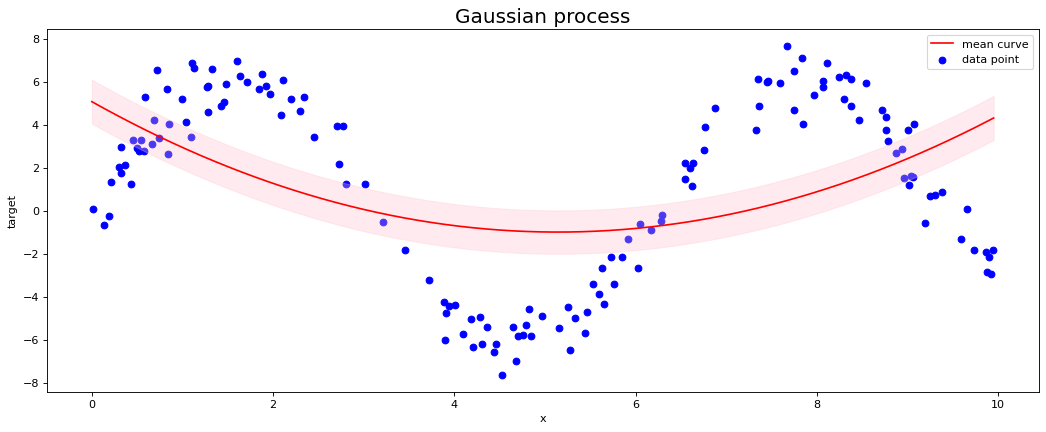

E_RMS of train= 3.8053745123407055
E_RMS of test= 3.9372608460509517


In [28]:
mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction_poly_GP(X_train,T_train,C,beta,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('Gaussian process', fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS(X_train,T_train,C,beta,X_train,T_train))
print("E_RMS of test=",ERMS(X_train,T_train,C,beta,X_test,T_test))

#2.2 exponential quardatic kernel


In [29]:
def exponential_kernel_matrix(p0,p1,p2,p3,X1,X2,inv_beta=0):
  N=X1.shape[0]
  M=X2.shape[0]
  kernel_matrix=np.zeros((N,M))
  for i in range(N):
    for j in range(M):
       dist=X1[i]-X2[j]
       det=dist.T@dist
       kernel_matrix[i][j]=p0*np.exp(-1*det*p1/2)+p2+p3*(X1[i].T@X2[j])
  return kernel_matrix+np.eye(N,M)*inv_beta
def prediction(p0,p1,p2,p3,X_data,T_data,x):
  CN=exponential_kernel_matrix(p0,p1,p2,p3,X_data.reshape(-1,1),X_data.reshape(-1,1),inv_beta=1)
  k_vec=exponential_kernel_matrix(p0,p1,p2,p3,X_data.reshape(-1,1),x.reshape(-1,1))
  c=exponential_kernel_matrix(p0,p1,p2,p3,x.reshape(-1,1),x.reshape(-1,1),inv_beta=1)
  
  CN_inv=np.linalg.pinv(CN)

  mean=k_vec.T@CN_inv@T_data
  var=c-k_vec.T@CN_inv@k_vec
  
  return np.ndarray.item(mean),np.ndarray.item(var)
#t=exponential_kernel_matrix(0,0,0,1,X_train.reshape(-1,1),X_train.reshape(-1,1))
#print(t)
#print(prediction(1,1,0,16,X_train,T_train,X_train[0]))


In [30]:
def ERMS_2(p0,p1,p2,p3,X_data,T_data,X,T):
  count=0
  for i in range(len(X)):
    m,v=prediction(p0,p1,p2,p3,X_data,T_data,X[i])
    count+=(T[i]-m)**2
  return np.sqrt(count/N)

four plots
----------------

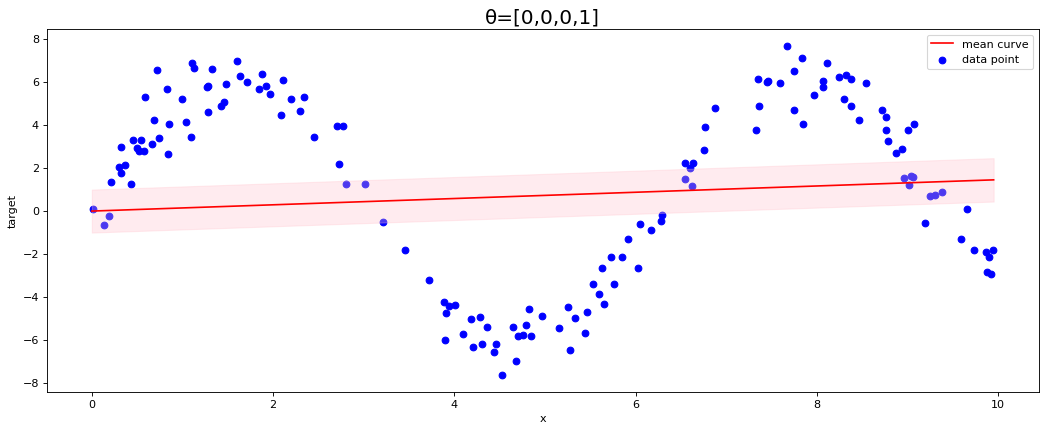

E_RMS of train= 4.374396158394972
E_RMS of test= 4.339365111505418


In [31]:
p0,p1,p2,p3=(0,0,0,1)

mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction(p0,p1,p2,p3,X_train,T_train,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
title="\u03B8=["+str(p0)+","+str(p1)+","+str(p2)+","+str(p3)+"]"
plt.title(title, fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_train,T_train))
print("E_RMS of test=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_test,T_test))

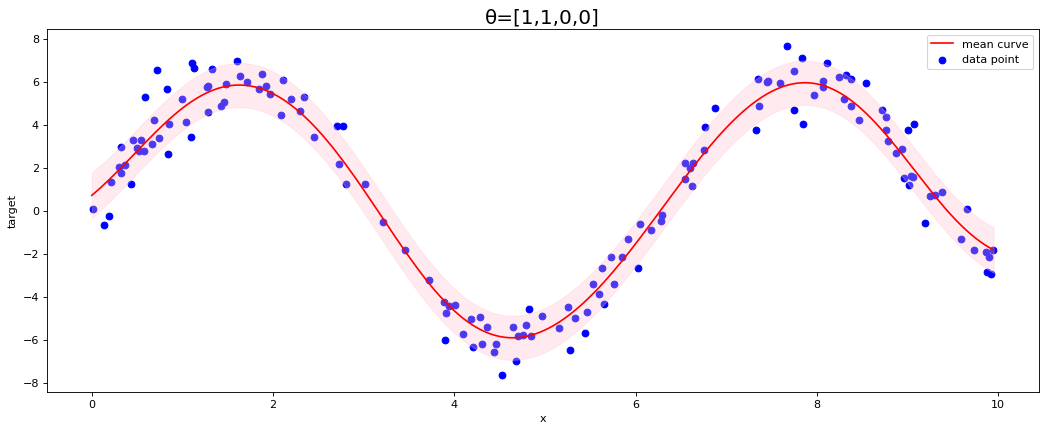

E_RMS of train= 0.8961522726566469
E_RMS of test= 0.9710402257936903


In [32]:
p0,p1,p2,p3=(1,1,0,0)

mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction(p0,p1,p2,p3,X_train,T_train,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
title="\u03B8=["+str(p0)+","+str(p1)+","+str(p2)+","+str(p3)+"]"
plt.title(title, fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_train,T_train))
print("E_RMS of test=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_test,T_test))

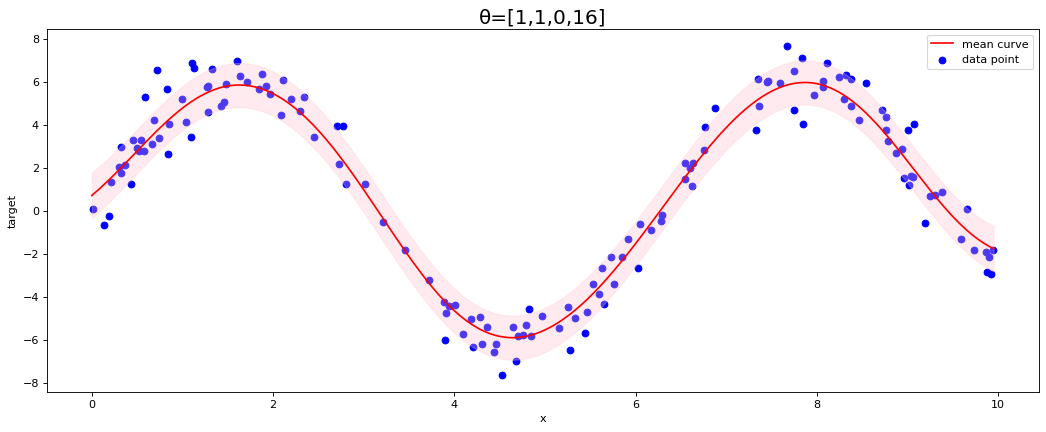

E_RMS of train= 0.8969169093498884
E_RMS of test= 0.9727259430604045


In [33]:
p0,p1,p2,p3=(1,1,0,16)

mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction(p0,p1,p2,p3,X_train,T_train,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
title="\u03B8=["+str(p0)+","+str(p1)+","+str(p2)+","+str(p3)+"]"
plt.title(title, fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_train,T_train))
print("E_RMS of test=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_test,T_test))

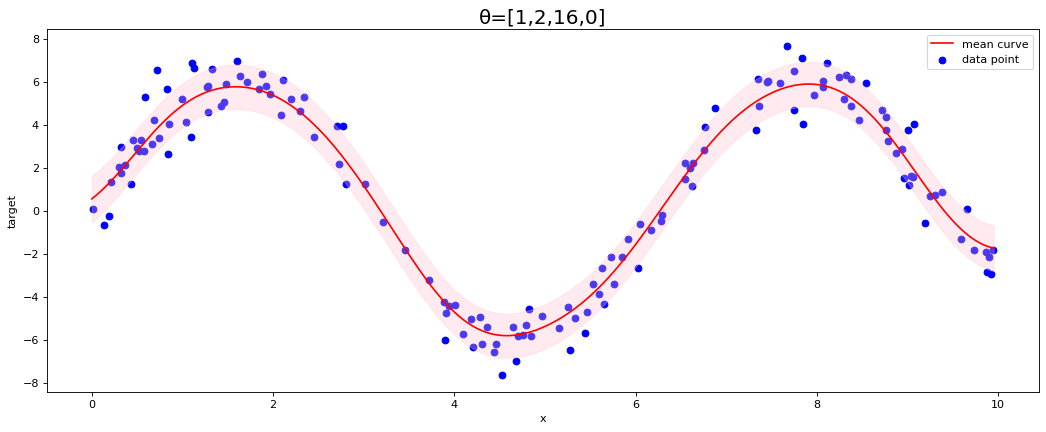

E_RMS of train= 0.8858631301051791
E_RMS of test= 0.9731049552239704


In [34]:
p0,p1,p2,p3=(1,2,16,0)

mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction(p0,p1,p2,p3,X_train,T_train,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
title="\u03B8=["+str(p0)+","+str(p1)+","+str(p2)+","+str(p3)+"]"
plt.title(title, fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_train,T_train))
print("E_RMS of test=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_test,T_test))

#2.3 Parameter tuning use ARD

In [35]:
def dC_dp0(p0,p1,p2,p3,X):
  N=len(X)
  diff_matrix=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      diff_matrix[i][j]=np.exp(-0.5*p1*((X[i]-X[j])**2))
  return diff_matrix

def dC_dp1(p0,p1,p2,p3,X):
  N=len(X)
  diff_matrix=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      diff_matrix[i][j]=p0*np.exp(-0.5*p1*((X[i]-X[j])**2))*(-0.5*((X[i]-X[j])**2))
  return diff_matrix
def dC_dp2(p0,p1,p2,p3,X):
  N=len(X)
  diff_matrix=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      diff_matrix[i][j]=1
  return diff_matrix
def dC_dp3(p0,p1,p2,p3,X):
  N=len(X)
  diff_matrix=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      diff_matrix[i][j]=X[i]*X[j]
  return diff_matrix 


In [39]:
lr=0.001
epochs=150
p0,p1,p2,p3=(1,2,16,0)#initial
p0_list=[]
p1_list=[]
p2_list=[]
p3_list=[]
for epoch in range(epochs):
  CN=exponential_kernel_matrix(p0,p1,p2,p3,X_train.reshape(-1,1),X_train.reshape(-1,1),inv_beta=1)
  CN_inv=np.linalg.pinv(CN)

  dp=dC_dp0(p0,p1,p2,p3,X_train)
  p0_update=-0.5*np.trace(CN_inv@dp)+0.5*T_train.reshape(1,-1)@CN_inv@dp@CN_inv@T_train.reshape(-1,1)

  dp=dC_dp1(p0,p1,p2,p3,X_train)
  p1_update=-0.5*np.trace(CN_inv@dp)+0.5*T_train.reshape(1,-1)@CN_inv@dp@CN_inv@T_train.reshape(-1,1)


  dp=dC_dp2(p0,p1,p2,p3,X_train)
  p2_update=-0.5*np.trace(CN_inv@dp)+0.5*T_train.reshape(1,-1)@CN_inv@dp@CN_inv@T_train.reshape(-1,1)

  dp=dC_dp3(p0,p1,p2,p3,X_train)
  p3_update=-0.5*np.trace(CN_inv@dp)+0.5*T_train.reshape(1,-1)@CN_inv@dp@CN_inv@T_train.reshape(-1,1)

  p0+=lr*p0_update
  p0=np.ndarray.item(p0)
  p0_list.append(p0)

  p1+=lr*p1_update
  p1=np.ndarray.item(p1)
  p1_list.append(p1)

  p2+=lr*p2_update
  p2=np.ndarray.item(p2)
  p2_list.append(p2)

  p3+=lr*p3_update
  p3=np.ndarray.item(p3)
  p3_list.append(p3)

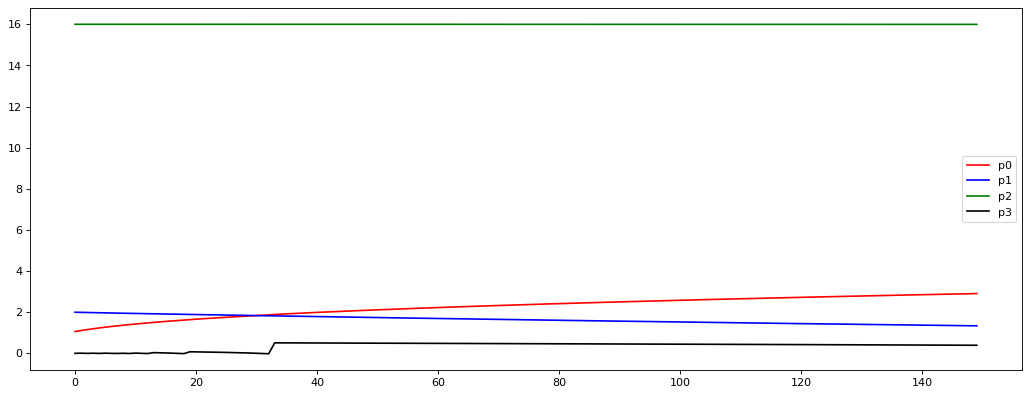

In [40]:
fig = plt.figure(figsize=(16, 6), dpi=80)

plt.plot(range(len(p0_list)),p0_list,color='red',label="p0")
plt.plot(range(len(p0_list)),p1_list,color='blue',label="p1")
plt.plot(range(len(p0_list)),p2_list,color='green',label="p2")
plt.plot(range(len(p0_list)),p3_list,color='black',label="p3")

plt.legend()
plt.show()

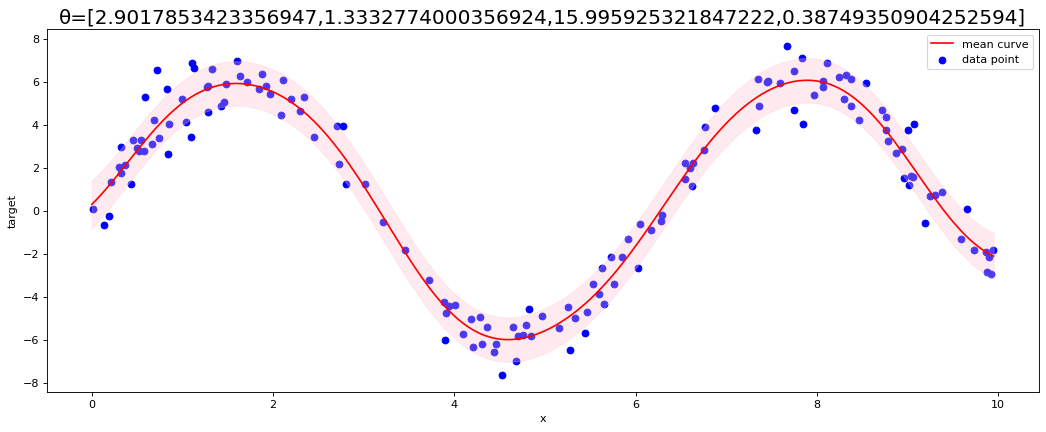

E_RMS of train= 0.8591093187890623
E_RMS of test= 0.962851997794751


In [41]:
mean_list=[]
var_list=[]
X_trace=np.arange(0,10,0.05)
for i in range(len(X_trace)):
  m,v=prediction(p0,p1,p2,p3,X_train,T_train,X_trace[i])
  mean_list.append(m)
  var_list.append(v)


fig = plt.figure(figsize=(16, 6), dpi=80)

#plt.xlim(0, 70) # 設定 x 軸座標範圍
#plt.ylim(0, 1) # 設定 y 軸座標範圍

plt.xlabel('x', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('target', fontsize="10") # 設定 y 軸標題內容及大小
title="\u03B8=["+str(p0)+","+str(p1)+","+str(p2)+","+str(p3)+"]"
plt.title(title, fontsize="18") # 設定圖表標題內容及大小

plt.scatter(X_train,T_train,label="data point",c="blue")

#plt.plot(X_train,mean_list, color='red',label="mean curve")
plt.plot(X_trace,mean_list,color='red',label="mean curve")
plt.fill_between(X_trace,mean_list+np.sqrt(var_list),mean_list-np.sqrt(var_list),color='#FFC0CB',alpha=0.3)
plt.legend()
plt.show()
print("E_RMS of train=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_train,T_train))
print("E_RMS of test=",ERMS_2(p0,p1,p2,p3,X_train,T_train,X_test,T_test))

#2.4 discussion

2.1  **polynomial basis**  

From the result of 2.1, polynomial basis seem to be not suitable for gaussian process.  
Maybe it is the lackness of shift cause polynomial basis perform bad compared to exponential kernel.  

2.2  **exponential quardratic kernel**  

After observing the plot of four different set of parameters,
the results is realy close for last three set of parameters.  
It is important for setting parameter0 and parameter1 to be non zero.
or it would perform like linear basis which performs bad in 2.1.  
Although,Gaussian process didn't provide a stable way for obtaining beta, the result is still quite satisfying.

2.3  **Parameter tuning use ARD**

After some trial and error, I found it is crucial for the initial parameters which we perform gradient descent on.  
The result is usually near the initial condition.If we go through with too large lr,  
the parameter may jump to some unsatisfying result.  
So, it's important for setting initial parameter and learning rate.
